# **APS1052: AI in Finance**
# Final Project : Multiple Stock Prediction
----

## Group members:

Name | Student ID | E-mail 
--- | --- | --- 
Keyan Ahmadi| 1002436740 |  k.ahmadi@mail.utoronto.ca
Bhagyashree Keswani| 1006790849 | bhagyashree.keswani@mail.utoronto.ca 
Nagarajan Jayaraman | 1006784044 | nagarajan.jayaraman@mail.utoronto.ca



### Summary of contents in this file:





1. Tuning and evaluating 4 classification models:
- Random forest
- Logistic Regression
- XG Boost
- LightGBM

2. Presenting:
- Statistical and financial performance metrics
- Shap plots
- Train and test equity curves
- Alpha lens evaluations results

### Importing all the Relevant Libraries

In [ ]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import seaborn as sns
from datetime import datetime
!pip install alphalens
import alphalens
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

import pywt
from scipy.special import ndtr
from scipy.stats import spearmanr
import tqdm
from functools import partial
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from pandas.plotting import scatter_matrix

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from scipy.stats import spearmanr
from scipy.stats import norm
from sklearn.pipeline import Pipeline
from scipy import stats

!pip install shap
import shap

### Importing the Data

#### Prior to importing the the dataset below ("Complete_DataFrame.csv"), we perfomed the following on the original dataset: 

1.   Clean the Data: Imputed all the NaN values with appropriate values.
2.   Feature Selection: We check for feature collinearity using SNS Heatmap, removed high correlated features in order to reduce model complexity, and picked the final features to train our model using Recursive Feature Elimination (RFE). 
3. Feature Tuning: Lastly, we wanted to check if feature smoothing is required for our data. We plotted Seasonal Decomposition, density and histogram plots for all the features. We concluded no feature smoothing is required based on our findings. 

All the above work has been completed in the "Data_Preparation" Notebook included in our submission. For more details on the data preparation steps, please refer to the "Data_Preparation" Notebook. 



In [ ]:
#Importing the final cleaned dataframe
Complete_DataFrame=pd.read_csv('Complete_DataFrame.csv') # The dataset is from the "Data_Preparation" Notebook
Complete_DataFrame.drop('Unnamed: 0',axis=1,inplace=True)
Complete_DataFrame['Year'] = pd.DatetimeIndex(Complete_DataFrame['date']).year
Complete_DataFrame.set_index(["TICKER","date"], inplace=True)
Complete_DataFrame

OPENPRC        PRC         vol    sprtrn       dix  \
TICKER date                                                               
AAPL   2011-01-03  325.64001  329.57001         0.0  0.011315  0.422730   
       2011-01-04  332.44000  331.29001  16438280.0 -0.001313  0.422730   
       2011-01-05  329.54999  334.00000  11444072.0  0.005007  0.422730   
       2011-01-06  334.71899  333.73001   9486655.0 -0.002123  0.422730   
       2011-01-07  333.98999  336.12000  11138250.0 -0.001845  0.422730   
...                      ...        ...         ...       ...       ...   
MSFT   2022-03-25  305.23001  303.67999  24464722.0  0.005066  0.497449   
       2022-03-28  304.32999  310.70001  22544459.0  0.007145  0.491188   
       2022-03-29  313.91000  315.41000  29560701.0  0.012257  0.473442   
       2022-03-30  313.76001  313.85999  30349457.0 -0.006294  0.500846   
       2022-03-31  313.89999  308.31000  28134409.0 -0.015653  0.472040   

                            gex   vixo  lag_ret0  lag_ret1  lag_ret2  ...  \
TICKER date                                                           ...   
AAPL   2011-01-03  2.763341e+09  17.94  0.000000  0.000000  0.000000  ...   
       2011-01-04  2.763341e+09  17.34  0.020882  0.000000  0.000000  ...   
       2011-01-05  2.763341e+09  17.81 -0.008693  0.020882  0.000000  ...   
       2011-01-06  2.763341e+09  16.80  0.015685 -0.008693  0.020882  ...   
       2011-01-07  2.763341e+09  17.31 -0.002178  0.015685 -0.008693  ...   
...                         ...    ...       ...       ...       ...  ...   
MSFT   2022-03-25  4.652304e+09  21.87  0.020358 -0.004559  0.002368  ...   
       2022-03-28  8.319654e+09  22.14 -0.002949  0.020358 -0.004559  ...   
       2022-03-29  9.140785e+09  19.70  0.031479 -0.002949  0.020358  ...   
       2022-03-30  8.005331e+09  19.38 -0.000478  0.031479 -0.002949  ...   
       2022-03-31  3.976160e+09  19.68  0.000446 -0.000478  0.031479  ...   

                     bb_low      macd  EMA For 50 Days        ADX  \
TICKER date                                                         
AAPL   2011-01-03  0.070503  0.000000         0.000000  27.808766   
       2011-01-04  0.070503  0.000000         0.000000  27.808766   
       2011-01-05  0.070503  0.000000         0.000000  27.808766   
       2011-01-06  0.070503  0.000000         0.000000  27.808766   
       2011-01-07  0.070503  0.000000         0.000000  27.808766   
...                     ...       ...              ...        ...   
MSFT   2022-03-25  0.092213  0.104605       299.455198  16.187812   
       2022-03-28  0.091832  0.388912       299.896171  16.502752   
       2022-03-29  0.112858  0.895229       300.504556  17.965364   
       2022-03-30  0.127970  1.473633       301.028299  19.947739   
       2022-03-31  0.126505  1.841548       301.313856  21.220961   

                   PutCallParity  PutCallRatio        BID        ASK  \
TICKER date                                                            
AAPL   2011-01-03     177.707767      0.595386  329.70999  329.72000   
       2011-01-04     178.826154      0.746331  331.29001  331.29999   
       2011-01-05     180.856263      0.566319  333.97000  334.00000   
       2011-01-06     164.545590      0.394729  333.64999  333.79001   
       2011-01-07     166.496499      0.711551  336.12000  336.26001   
...                          ...           ...        ...        ...   
MSFT   2022-03-25     -36.362854      0.542836  303.67999  303.69000   
       2022-03-28     -36.362854      0.542836  310.75000  310.76001   
       2022-03-29     -36.362854      0.542836  315.41000  315.42001   
       2022-03-30     -36.362854      0.542836  313.73999  313.85999   
       2022-03-31     -36.362854      0.542836  308.07999  308.10999   

                    RetFut1  Year  
TICKER date                        
AAPL   2011-01-03  0.020882  2011  
       2011-01-04 -0.008693  2011  
       2011-01-05  0.015685  2011  
       2011-01-06 -0.002178 

In [ ]:
#Defining the scoring function to evaluate different classification models
def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    return phi_k_corr

myscorer_cla = make_scorer(phi_k, greater_is_better=True)

Please note:

Assets Selected: 1- Apple (AAPL), 2-, Microsoft(MSFT), 3- IBM (IBM).

## 1. Machine Learning Model Implementation

To find the best models available for our dataset we used Microsoft Azure Automated-ML service. 

30+ machine learning algorithms were implemented using Azure Automated-ML service. The models with the best weighted AUC were selected for our dataset.

Defining a function below to build different classification models. 





Details of this function:

- Target: 1 if %daily returns in open price >0
else Target:0

- Train data: years 2011 to 2019; 
Test data: years 2020 to 2022

- The model pipeline encompasses data preprocessing(scaling), hyperparameter tuning and model fitting steps.

- The model is tuned using cross validation time series split of 5. The models are evaluated based on the phik corr scoring function.

- The function returns the value of predicted daily returns and values of different performance metrics.

In [ ]:
def build_model_classification(Scaler,Model,Param_grid):
  STOCKS = Complete_DataFrame.index.get_level_values('TICKER').unique()

  splitter = TimeSeriesSplit(n_splits=5)
  
  df2=[]
  df = []
  Spr = []
  dailyRet_train_list=[]
  dailyRet_test_list=[]
  cagr_train_list=[]
  cagr_test_list=[]
  ratio_train_list=[]
  ratio_test_list=[]
  best_model_list=[]
  phik_list=[]
  acc_list=[]

  for i in STOCKS:
    df = Complete_DataFrame.loc[Complete_DataFrame.index.get_level_values('TICKER') == i]

    #build labels (0 and 1) based on percent returns of open price in the training set
    
    df['label']=0
    df.loc[df['RetFut1']>0,'label']=1
    df1 = df.copy(deep=True)

    X_train = df[(df.Year.isin([2011,2012,2013,2014,2015,2016,2017,2018,2019]))]
    X_test = df[(df.Year.isin([2020,2021,2022]))]

    Y_train= X_train['label']
    RF_train = X_train['RetFut1']
    X_train.drop(['Year','RetFut1','label'],axis=1,inplace=True)

    Y_test = X_test['label']
    RF_test = X_test['RetFut1']
    X_test.drop(['Year','RetFut1','label'],axis=1,inplace=True)

    #Grid Search to tune hyperparamter and determine the best values for each asset
    scaler=Scaler
    model = Model 

    pipe = Pipeline([("scaler", scaler), ("model", model)])

    #set of parameters for random search
    param_grid = Param_grid
    grid_search = GridSearchCV(pipe, param_grid, cv=splitter,scoring=myscorer_cla, return_train_score=True)
    grid_search.fit(X_train.values, Y_train.values.ravel())

    best_parameters = grid_search.best_params_;
    print('The best hyperparamters for',i)
    print(best_parameters)
    best_model = grid_search.best_estimator_;
    best_model_list.append(best_model)

    predictions_train = best_model.predict(X_train.values)  #Use best_model parameters for predictions
    predictions_test = best_model.predict(X_test.values);

    dailyRet_train = pd.Series(predictions_train).fillna(0).values * RF_train   #calcualate Percent Returns from predicted classes
    dailyRet_test = pd.Series(predictions_test).fillna(0).values * RF_test
  
    #using predicted returns
    Retpred = pd.concat([dailyRet_train,dailyRet_test])
    Retpred.name = 'RetPred'
    Retpred = pd.DataFrame(Retpred)
    df=df1.join(Retpred,on = ['TICKER','date'], rsuffix='RetPred')
    df2.append(df)

    dailyRet_train_list.append(dailyRet_train)
    dailyRet_test_list.append(dailyRet_test)
    cumret_tr = np.cumprod(dailyRet_train +1) - 1
    cumret_ts = np.cumprod(dailyRet_test +1) - 1


    # calculate Spearmann's rank coeff for each Asset and save
    S =stats.spearmanr(Y_test,predictions_test)[0]   
    Spr.append(S)

    #Compound Annual Growth Rate - Training
    cagr_train = (1 + cumret_tr[-1]) ** (252 / len(cumret_tr)) - 1
    cagr_train_list.append(cagr_train)
      
    # Compound Annual Growth Rate - Test
    cagr_test = (1 + cumret_ts[-1]) ** (252 / len(cumret_ts)) - 1
    cagr_test_list.append(cagr_test)
      
    # Sharpe Ratio - Training
    ratio_train = (252.0 ** (1.0/2.0)) * np.mean(dailyRet_train) / np.std(dailyRet_train)
    ratio_train_list.append(ratio_train)
      
    # Sharpe Ratio - Test
    ratio_test = (252.0 ** (1.0/2.0)) * np.mean(dailyRet_test) / np.std(dailyRet_test)
    ratio_test_list.append(ratio_test)

    phik_list.append(phi_k(Y_test.values.ravel(), predictions_test))

    acc_list.append(accuracy_score(Y_test.values.ravel(), predictions_test))

  return dailyRet_train_list,\
  dailyRet_test_list,\
  STOCKS,\
  Spr,\
  best_model_list,\
  cagr_train_list,\
  cagr_test_list,\
  ratio_train_list,\
  ratio_test_list,\
  phik_list,\
  acc_list,\
  df2

### Model 1: Random Forest Classifier 

In [ ]:
# Model 1: Random Forest Classifier
Scaler = StandardScaler()
Model= RandomForestClassifier()

param_grid={
    "model__max_depth":[4, 8, 15], 
    "model__n_estimators":[100, 250, 500],
    'model__min_samples_leaf': [1,3,8],
    'model__min_samples_split': [2,6,10],
    'model__criterion': ["gini", "entropy", "log_loss"],
}

rfc=build_model_classification(Scaler,Model,param_grid)

The best hyperparamters for AAPL
{'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
The best hyperparamters for IBM
{'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
The best hyperparamters for MSFT
{'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}


### Model 2: Logistic Regression

In [ ]:
# Model 2: Logistic Regression 

Scaler = StandardScaler()

# Defining model
from sklearn.linear_model import LogisticRegression
Model = LogisticRegression(random_state=1052)

# Defining Param Grid
param_grid={
    "model__C":[0.01,0.1, 1,5,10,50], 
    "model__solver":['newton-cg', 'lbfgs', 'saga', 'liblinear'],
    'model__penalty':['l1','l2','elasticnet'],
    'model__max_iter': [10,100,1000]
    }

logreg = build_model_classification(Scaler,Model,param_grid)

The best hyperparamters for AAPL
{'model__C': 0.01, 'model__max_iter': 10, 'model__penalty': 'l1', 'model__solver': 'saga'}
The best hyperparamters for IBM
{'model__C': 0.01, 'model__max_iter': 10, 'model__penalty': 'l1', 'model__solver': 'saga'}
The best hyperparamters for MSFT
{'model__C': 0.01, 'model__max_iter': 10, 'model__penalty': 'l1', 'model__solver': 'saga'}


### Model 3: LightGBM Classifier

In [ ]:
# Model 3: LightGBM Classifier

Scaler = StandardScaler()

# Defining model
from lightgbm import LGBMClassifier
Model = LGBMClassifier(random_state=1052)

# Defining Param Grid
param_grid = {
    "model__num_leaves" : [8, 32, 256],
    "model__max_depth": [3, 5, 8],
    "model__boosting_type" : ["gbdt","dart","goss"],
    "model__n_estimator": [50, 100, 1000],
    "model__learning_rate": [1, 0.1, 0.05]  
}

# Note: In the LGBM Classifier model, the main hyper parameter to tune is num_leaves. num_leaves is the parameter that will control the complexity of the model as 
# it controls the amount of decision leaves in a single tree. The num_leaves can be determine by using this formula: 2^(max_depth). 

LGBM_classifier = build_model_classification(Scaler,Model,param_grid)

The best hyperparamters for AAPL
{'model__boosting_type': 'gbdt', 'model__learning_rate': 1, 'model__max_depth': 3, 'model__n_estimator': 50, 'model__num_leaves': 8}
The best hyperparamters for IBM
{'model__boosting_type': 'gbdt', 'model__learning_rate': 1, 'model__max_depth': 3, 'model__n_estimator': 50, 'model__num_leaves': 8}
The best hyperparamters for MSFT
{'model__boosting_type': 'gbdt', 'model__learning_rate': 1, 'model__max_depth': 3, 'model__n_estimator': 50, 'model__num_leaves': 8}


### Model 4: XGB Classifier

In [ ]:
# Model 4: XGB Classifier

Scaler = StandardScaler()

# Defining the XGB Classifier model
import xgboost as xgb
Model = xgb.XGBClassifier(random_state=1052)

# Defining Param Grid
param_grid = {
    "model__max_depth": [4, 8, 10],            # Max Depth of the tree. The higher this number, the more complex the model, which increases the likelihood to overfit.
    "model__learning_rate": [0.1, 0.05, 0.01], # Learning Rate
    "model__gamma": [0.20, 0.5],
    "model__colsample_bytree": [0.5, 0.9],     # Subset of the features that can be utilized to train each tree. High values --> Approx. all Features can be used 
    "model__reg_lambda": [0, 0.5, 0.7],        # L2 regularization term on the weights.
    "model__subsample": [0.5, 0.9],            # Sub-sample of the train data that can be utilized to train each tree. Low values -> high chance to underfit, High values -> high chance to overfit
}

XGB_classifier = build_model_classification(Scaler,Model,param_grid)

The best hyperparamters for AAPL
{'model__colsample_bytree': 0.5, 'model__gamma': 0.2, 'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__reg_lambda': 0, 'model__subsample': 0.5}
The best hyperparamters for IBM
{'model__colsample_bytree': 0.5, 'model__gamma': 0.2, 'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__reg_lambda': 0, 'model__subsample': 0.5}
The best hyperparamters for MSFT
{'model__colsample_bytree': 0.5, 'model__gamma': 0.2, 'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__reg_lambda': 0, 'model__subsample': 0.5}


## 2. Shap Plots:

We decided to use Shap plots in this project to better understand why models behave and perfrom they way they do. Shap plots are used to increase model’s transparency and interpretability and make the models seem like less of a black box.

Defining a Function to Make Interpretable Shap Plots

In [ ]:
# The following function is used to plot the Shap Summary plots for each classification model

def shap_plot(best_model,STOCK): 
  df = Complete_DataFrame.loc[Complete_DataFrame.index.get_level_values('TICKER') == STOCK]
  df['label']=0
  df.loc[df['RetFut1']>0,'label']=1

  X_train = df[(df.Year.isin([2011,2012,2013,2014,2015,2016,2017,2018,2019]))]
  Y_train = X_train['label']
  X_train.drop(['Year','label',"RetFut1"],axis=1,inplace=True)

  X_test = df[(df.Year.isin([2020,2021,2022]))]
  Y_test = X_test['label']
  X_test.drop(['Year','label',"RetFut1"],axis=1,inplace=True)

  median = X_train.median().values.reshape((1,X_train.shape[1]))
  explainer = shap.KernelExplainer(best_model.predict_proba, median)
  shap_values = explainer.shap_values(X_test)

  print('--------------------------------------')
  print('Shap plot for ',STOCK)
  print('--------------------------------------')

  shap.initjs()
  shap.summary_plot(shap_values[0], X_test.iloc[0:1000,:], show=False)
  plt.title('Shap summary plot for ({:s})'.format(STOCK))
  plt.show()

### Shap Plots: Random Forest Classifier Model

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  AAPL
--------------------------------------


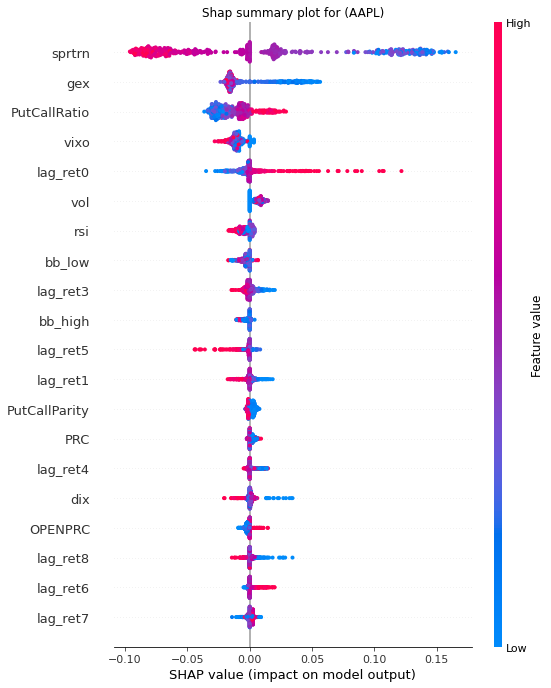

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  IBM
--------------------------------------


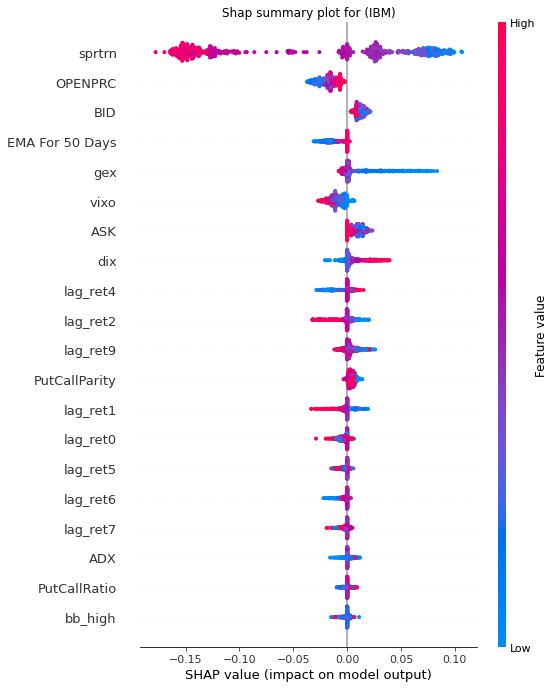

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  MSFT
--------------------------------------


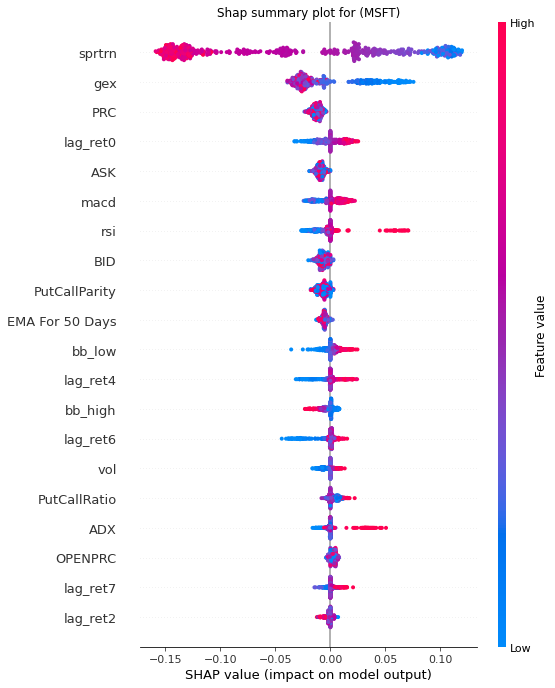

In [ ]:
# Shap Plots for Random Forest Classifier Model
shap_plot(rfc[4][0],'AAPL')
shap_plot(rfc[4][1],'IBM')
shap_plot(rfc[4][2],'MSFT')

The Shap plot indicates that "sprtrn" variable is the most important feature when making predictions for all three stocks. 

All features contribute to the model’s decision making processs to a degree. 

Model predictions is shaped by both individual stock and general market conditions, however, the general market condition has more influence. 

The high (red) and low (blue) values are clearly defined, with no overlapping w.r.t Shap values. This leads to the model making definite predictions since no inconsistency will exist between the features

### Shap Plots: Logistic Regression Model

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  AAPL
--------------------------------------


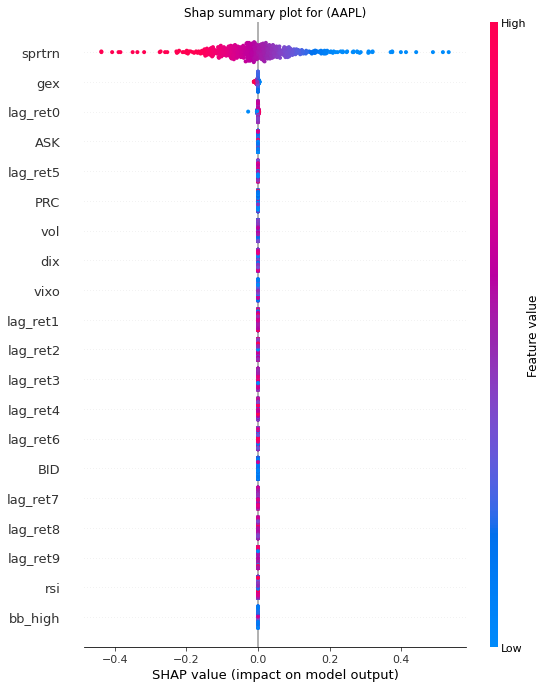

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  IBM
--------------------------------------


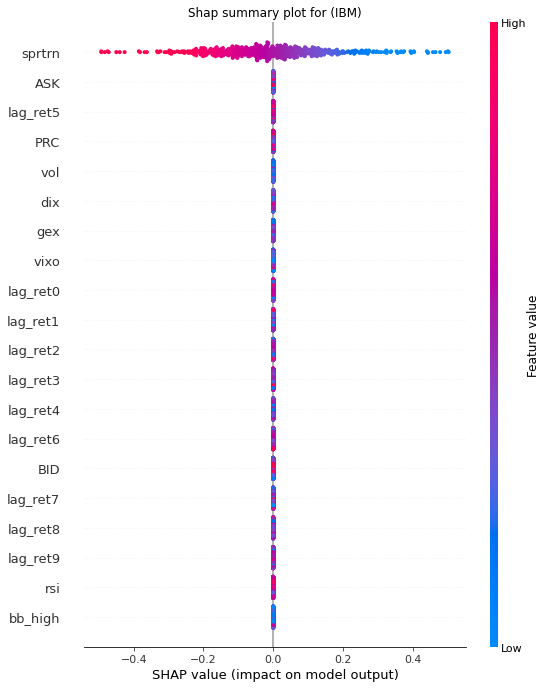

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  MSFT
--------------------------------------


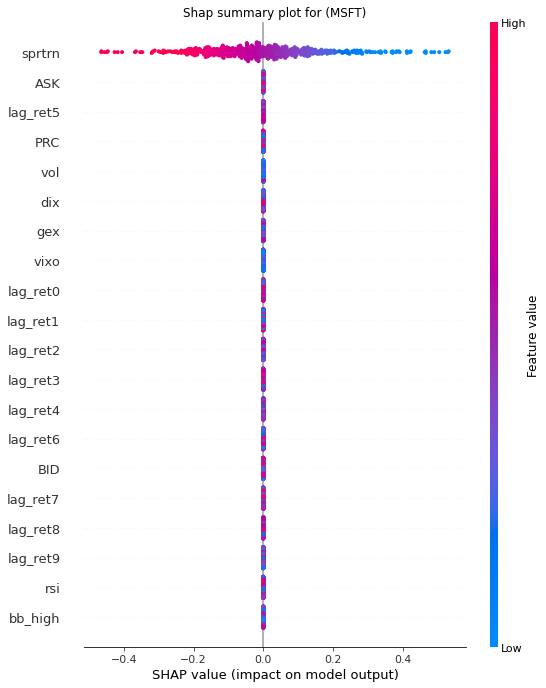

In [ ]:
# Shap Plots for Logistic Regression Model
shap_plot(logreg[4][0],'AAPL')
shap_plot(logreg[4][1],'IBM')
shap_plot(logreg[4][2],'MSFT')

The Shap plot indicates that "sprtrn" variable is the most important feature when making predictions. 

No other features contribute to the model’s decision making. 

Model predictions is only influenced by the general market behavior. 

The Logistic Regression model performed well as seen in section 3 later on, despite the model being only influenced by 1 feature. 

This may be indicative that emphasizing the general market feature will lead to better predicting future returns.

### Shap Plot: LightGBM Classifier Model

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  AAPL
--------------------------------------


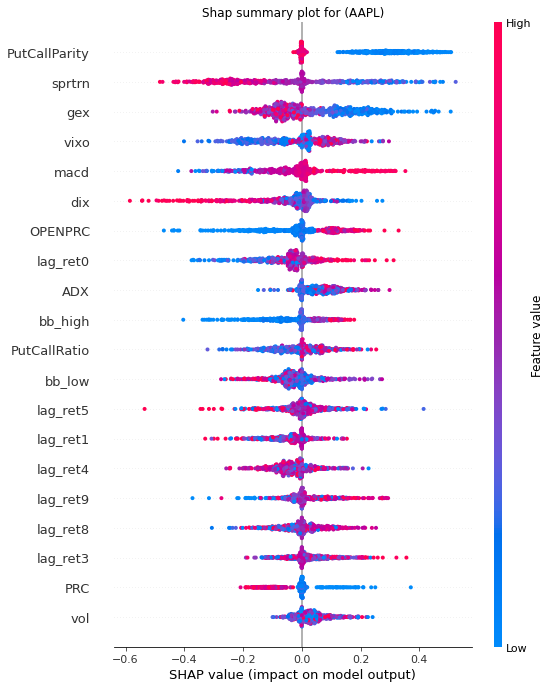

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  IBM
--------------------------------------


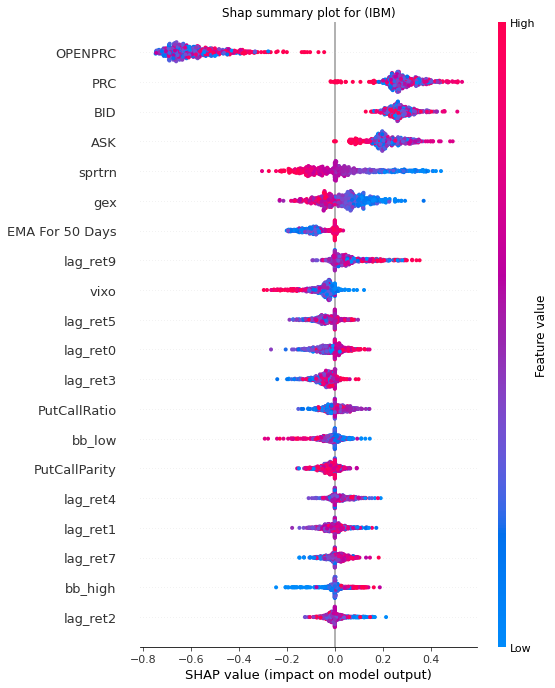

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  MSFT
--------------------------------------


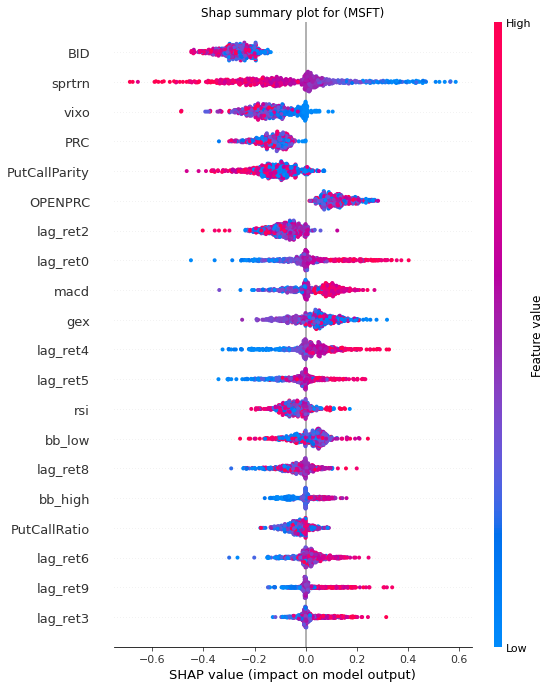

In [ ]:
# Shap Plots for LightGBM Classifier Model
shap_plot(LGBM_classifier[4][0],'AAPL')
shap_plot(LGBM_classifier[4][1],'IBM')
shap_plot(LGBM_classifier[4][2],'MSFT')

The Shap plots indicates that "PutCallParity", "OPENPRC", and "BID" variables are the most important feature when making predictions for Apple, IBM, and Microsoft, respectively.

All features influence the model’s decision making.

Model predictions is influenced by the general market behavior and single stock conditions. 


For all 3 plots, the high (red) and low (blue) values are conflicting within certain regions of the Shap Values. This may lead to the model making erroneous predictions since inconsistencies will exist within the features.

### Shap Plot: XGB Classifier Model

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  AAPL
--------------------------------------


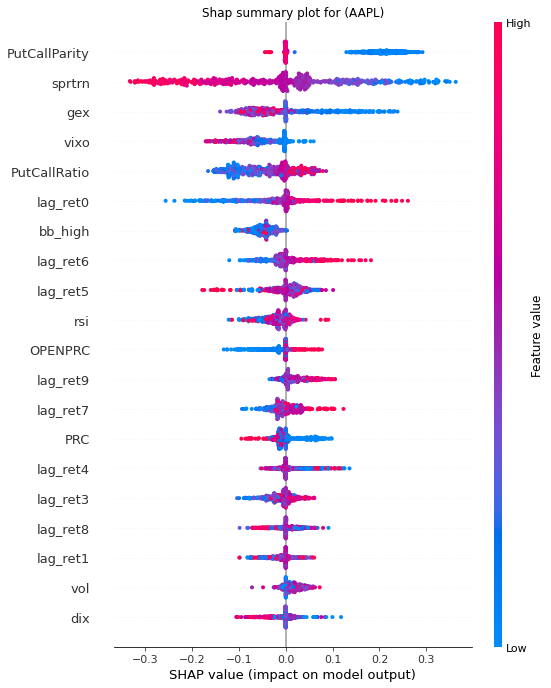

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  IBM
--------------------------------------


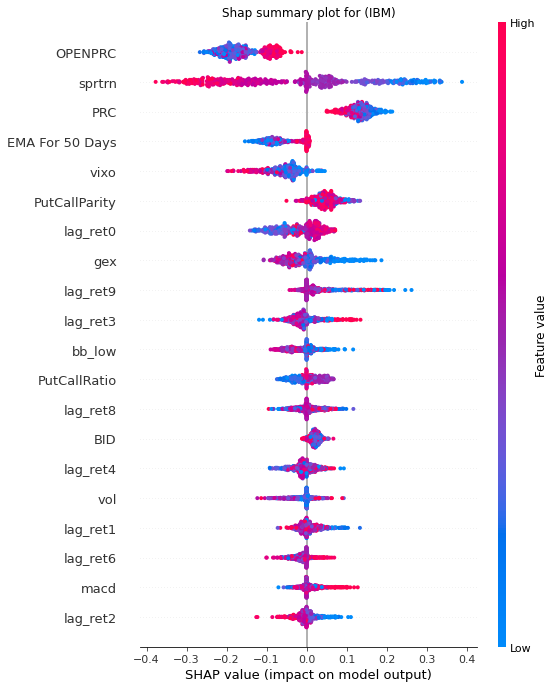

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  MSFT
--------------------------------------


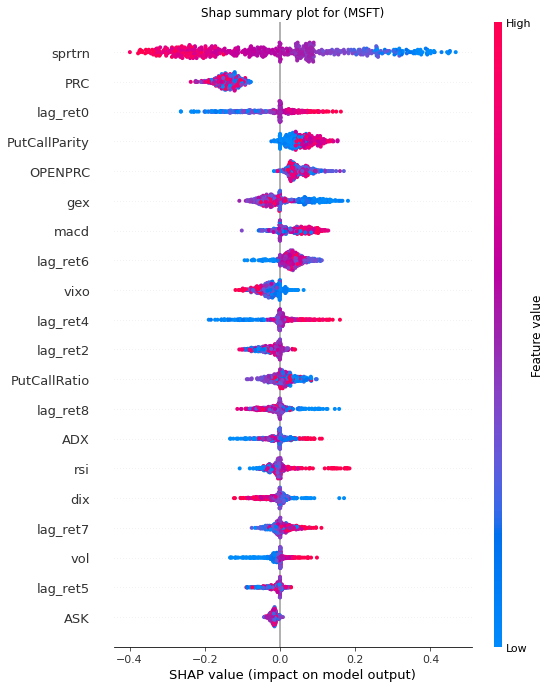

In [ ]:
# Shap Plots for XGB Classifier Model
shap_plot(XGB_classifier[4][0],'AAPL')
shap_plot(XGB_classifier[4][1],'IBM')
shap_plot(XGB_classifier[4][2],'MSFT')

The Shap plots indicates that "PutCallParity", "OPENPRC", and "sprtrn" variables are the most important feature when making predictions for Apple, IBM, and Microsoft, respectively. 

All features influence the model’s decision making. 

Model predictions is influenced by the general market behavior and single stock conditions. 

For Microsoft:

The "PRC" feature, the high (red) and low (blue) values are conflicting within small window of Shap Values. This may lead to the model making erroneous predictions since inconsistencies will exist within this feature. 

# 3. Displaying the Statistical and Financial Performance Metrics:



Metrics calculated:

- Accuracy
- CAGR
- Sharpe ratio
- Spearman rank coefficient
- Phik corr

In [ ]:
#printing out the results
indexes =  ['Accuracy','CAGR Train','CAGR Test','Sharpe Ratio Train','Sharpe Ratio Test','Spearman Rank Coeff.','Phik Corr']
columns =  ['AAPL', 'IBM', 'MSFT']
models = ['Random Forest Classifier','Logistic Regression','Light Gradient Boosted Machine(LGBM) Classifier','XGBoost Classifier']
rfc_values  =  [rfc[-2],rfc[5],rfc[6],rfc[7],rfc[8],rfc[3],rfc[-3]]
logreg_values  =  [logreg[-2],logreg[5],logreg[6],logreg[7],logreg[8],logreg[3],logreg[-3]]
LGBM_classifier_values  =  [LGBM_classifier[-2],LGBM_classifier[5],LGBM_classifier[6],LGBM_classifier[7],LGBM_classifier[8],LGBM_classifier[3],LGBM_classifier[-3]]
XGB_classifier_values  =  [XGB_classifier[-2],XGB_classifier[5],XGB_classifier[6],XGB_classifier[7],XGB_classifier[8],XGB_classifier[3],XGB_classifier[-3]]


rfc_df = pd.DataFrame(rfc_values,columns=columns,index=indexes)
logreg_df = pd.DataFrame(logreg_values,columns=columns,index=indexes)
LGBM_classifier_df = pd.DataFrame(LGBM_classifier_values,columns=columns,index=indexes)
XGB_classifier_df = pd.DataFrame(XGB_classifier_values,columns=columns,index=indexes)


final_cla_df = pd.concat([rfc_df,logreg_df,LGBM_classifier_df,XGB_classifier_df],keys=models)
final_cla = final_cla_df.unstack(level=1)

## 3.1 For Apple:

In [ ]:
final_cla.iloc[:,0:7]

AAPL             \
                                                 Accuracy CAGR Train   
Random Forest Classifier                         0.652557   0.826136   
Logistic Regression                              0.670194   0.468629   
Light Gradient Boosted Machine(LGBM) Classifier  0.592593   4.081365   
XGBoost Classifier                               0.661376   2.614856   

                                                                              \
                                                CAGR Test Sharpe Ratio Train   
Random Forest Classifier                         0.771330           2.071981   
Logistic Regression                              0.729931           1.463846   
Light Gradient Boosted Machine(LGBM) Classifier  0.237258           9.597062   
XGBoost Classifier                               0.790903           6.845716   

                                                                   \
                                                Sharpe Ratio Test   
Random Forest Classifier                                 1.562203   
Logistic Regression                                      1.533715   
Light Gradient Boosted Machine(LGBM) Classifier          0.939230   
XGBoost Classifier                                       1.596044   

                                                                                
                                                Spearman Rank Coeff. Phik Corr  
Random Forest Classifier                                    0.303325       0.0  
Logistic Regression                                         0.335170       0.0  
Light Gradient Boosted Machine(LGBM) Classifier             0.190456       0.0  
XGBoost Classifier                                          0.314886       0.0

Observations from the metrics:

- Logistic regression provides the highest accuracy. This could be because Logistic Regression is less prone to overfitting data considering L1 regularization has been incorporated in the model, and thus is better able to learn the market’s trends from the train data. ​
- XG boost gives the highest test CAGR and Sharpe ratio.
- The spearman rank is similar for all models except Light GBM for which it is low.
- Lower Sharpe ratios indicate Apple being a riskier stock than its competitors.

## 3.2 For IBM:

In [ ]:
final_cla.iloc[:,7:14]

IBM             \
                                                 Accuracy CAGR Train   
Random Forest Classifier                         0.611993   0.668601   
Logistic Regression                              0.610229   0.525609   
Light Gradient Boosted Machine(LGBM) Classifier  0.590829   1.840798   
XGBoost Classifier                               0.587302   1.297373   

                                                                              \
                                                CAGR Test Sharpe Ratio Train   
Random Forest Classifier                         0.661708           4.152088   
Logistic Regression                              0.561702           3.111116   
Light Gradient Boosted Machine(LGBM) Classifier  0.537833           9.630509   
XGBoost Classifier                               0.341367           6.876489   

                                                                   \
                                                Sharpe Ratio Test   
Random Forest Classifier                                 2.664515   
Logistic Regression                                      2.280662   
Light Gradient Boosted Machine(LGBM) Classifier          2.023795   
XGBoost Classifier                                       1.475387   

                                                                                
                                                Spearman Rank Coeff. Phik Corr  
Random Forest Classifier                                    0.223964       0.0  
Logistic Regression                                         0.221837       0.0  
Light Gradient Boosted Machine(LGBM) Classifier             0.209215       0.0  
XGBoost Classifier                                          0.180206       0.0

Observations from the metrics:

- Random forest and Logistic have the highest accuracies.
- Random forest gives highest test CAGR and sharpe ratios.
- Spearman rank coeff is similar for all models.


## 3.3 For Microsoft:

In [ ]:
final_cla.iloc[:,14:]

MSFT             \
                                                 Accuracy CAGR Train   
Random Forest Classifier                         0.640212   1.125952   
Logistic Regression                              0.659612   0.852481   
Light Gradient Boosted Machine(LGBM) Classifier  0.587302   2.821877   
XGBoost Classifier                               0.638448   1.927792   

                                                                              \
                                                CAGR Test Sharpe Ratio Train   
Random Forest Classifier                         1.733190           4.834864   
Logistic Regression                              1.778928           3.721376   
Light Gradient Boosted Machine(LGBM) Classifier  0.862936           9.666891   
XGBoost Classifier                               1.598776           7.130159   

                                                                   \
                                                Sharpe Ratio Test   
Random Forest Classifier                                 4.756625   
Logistic Regression                                      5.129995   
Light Gradient Boosted Machine(LGBM) Classifier          2.616311   
XGBoost Classifier                                       4.353688   

                                                                                
                                                Spearman Rank Coeff. Phik Corr  
Random Forest Classifier                                    0.284399       0.0  
Logistic Regression                                         0.317968       0.0  
Light Gradient Boosted Machine(LGBM) Classifier             0.172351       0.0  
XGBoost Classifier                                          0.277171       0.0

Observations from the metrics:
- Random forest and Logistic have the highest accuracies.
- Logistic gives highest test CAGR and sharpe ratios.
- The ideal sharpe ratios indicate Microsoft being less volatile while maintaining high rewards for investors.

To summarise, the best models for the 3 stocks are:
- Apple: Logistic regression and XG Boost
- IBM: Random forest and Logistic regression
- Microsoft: Random forest and Logistic regression

# 4. Train and Test Equity Curves for all Models:

In [ ]:
def train_test_equity_curves(STOCK,dailyRet_train_model1,dailyRet_train_model2,dailyRet_train_model3,dailyRet_train_model4,\
                             dailyRet_test_model1,dailyRet_test_model2,dailyRet_test_model3,dailyRet_test_model4):
  
  df=[]
  all_cumrets_train=[]
  all_cumrets_test=[]
  df = Complete_DataFrame.loc[Complete_DataFrame.index.get_level_values('TICKER') == STOCK]

  #build labels (0 and 1) based on percent returns of open price in the training set
  
  df['label']=0
  df.loc[df['RetFut1']>0,'label']=1
  df1 = df.copy(deep=True)

  X_train = df[(df.Year.isin([2011,2012,2013,2014,2015,2016,2017,2018,2019]))]
  X_test = df[(df.Year.isin([2020,2021,2022]))]

  Y_train= X_train['label']
  X_train.drop(['Year','RetFut1','label'],axis=1,inplace=True)

  Y_test = X_test['label']
  X_test.drop(['Year','RetFut1','label'],axis=1,inplace=True)

  # Calculate Cross validated cumulative returns for train data based on daily returns obtained from the build model function above 
  cumret_train_model1 = np.cumprod(dailyRet_train_model1.values +1) - 1     
  cumret_train_model2 = np.cumprod(dailyRet_train_model2.values +1) - 1
  cumret_train_model3 = np.cumprod(dailyRet_train_model3.values +1) - 1
  cumret_train_model4 = np.cumprod(dailyRet_train_model4.values +1) - 1

  #Append the Cross validated cumulative returns of all models to a list
  all_cumrets_train.append(cumret_train_model1)
  all_cumrets_train.append(cumret_train_model2)
  all_cumrets_train.append(cumret_train_model3)
  all_cumrets_train.append(cumret_train_model4)
  
  #Plotting the Cross validated cumulative returns for train set
  plt.figure(figsize=(10,5))
  sns.set(style="darkgrid")
  plt.plot(Y_train.index.get_level_values('date')[:500], cumret_train_model1[:500], label ='Random Forest Classifier')   #plot the cumulative returns for comparison (train set)
  plt.plot(Y_train.index.get_level_values('date')[:500], cumret_train_model2[:500], label = 'Logistic Regression')
  plt.plot(Y_train.index.get_level_values('date')[:500], cumret_train_model3[:500], label = 'LGBM Classifier')
  plt.plot(Y_train.index.get_level_values('date')[:500], cumret_train_model4[:500], label = 'XGB Classifier')
  plt.title('Cross-validated cumulative returns on train set ' + STOCK)
  plt.ylabel('Cumulative Returns')
  plt.xlabel('Date')
  plt.xticks(Y_train[:500].index.get_level_values('date')[::40], rotation = 'vertical')
  plt.legend()
  plt.tight_layout()

  #Plot the Normalized Cross validated cumulative returns for train set
  plt.figure(figsize=(10,5))
  plt.plot(Y_train.index.get_level_values('date')[:500], np.average(np.vstack(list(all_cumrets_train)), axis=0)[:500],'--')
  plt.title('Normalized cumulative returns-train set ' + STOCK)
  plt.xticks(Y_train[:500].index.get_level_values('date')[::40], rotation = 'vertical')
  plt.ylabel('Cumulative Returns')
  plt.xlabel('Date')
  plt.tight_layout()

  # Calculate Cross validated cumulative returns for test data based on daily returns obtained from the build model function above 
  cumret_test_model1 = np.cumprod(dailyRet_test_model1.values +1) - 1
  cumret_test_model2 = np.cumprod(dailyRet_test_model2.values +1) - 1
  cumret_test_model3 = np.cumprod(dailyRet_test_model3.values +1) - 1
  cumret_test_model4 = np.cumprod(dailyRet_test_model4.values +1) - 1
 
  #Append the Cross validated cumulative returns of all models to a list
  all_cumrets_test.append(cumret_test_model1)
  all_cumrets_test.append(cumret_test_model2)
  all_cumrets_test.append(cumret_test_model3)
  all_cumrets_test.append(cumret_test_model4)

  #Plot the Cross validated cumulative returns for train set
  plt.figure(figsize=(10,5))
  plt.plot(Y_test.index.get_level_values('date').values, cumret_test_model1, label ='Random Forest Classifier')   #plot the cumulative returns for comparison (train set)
  plt.plot(Y_test.index.get_level_values('date').values, cumret_test_model2, label = 'Logistic Regression')
  plt.plot(Y_test.index.get_level_values('date').values, cumret_test_model3, label = 'LGBM Classifier')
  plt.plot(Y_test.index.get_level_values('date').values, cumret_test_model4, label = 'XGB Classifier')
  plt.title('Cross-validated cumulative returns on test set ' + STOCK)
  plt.ylabel('Cumulative Returns')
  plt.xlabel('Date')
  plt.xticks(Y_test.index.get_level_values('date')[::30], rotation = 'vertical')
  plt.legend()
  plt.tight_layout()

  #Plot the Normalized Cross validated cumulative returns for test set
  plt.figure(figsize=(10,5))
  plt.plot(Y_test.index.get_level_values('date').values, np.average(np.vstack(list(all_cumrets_test)), axis=0),'--')
  plt.title('Normalized cumulative returns-test set ' + STOCK)
  plt.xticks(Y_test.index.get_level_values('date')[::30], rotation = 'vertical')
  plt.ylabel('Cumulative Returns')
  plt.xlabel('Date')
  plt.tight_layout()

## 4.1 For Apple:

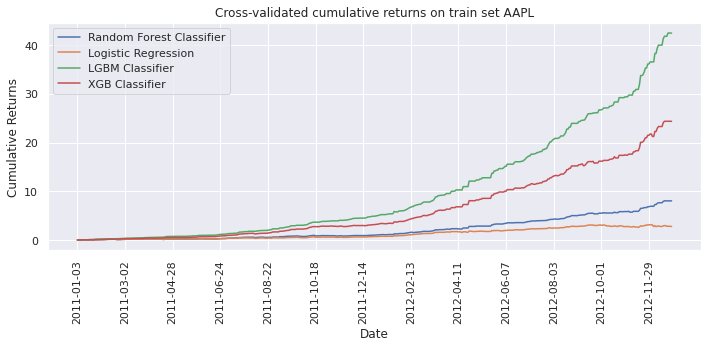

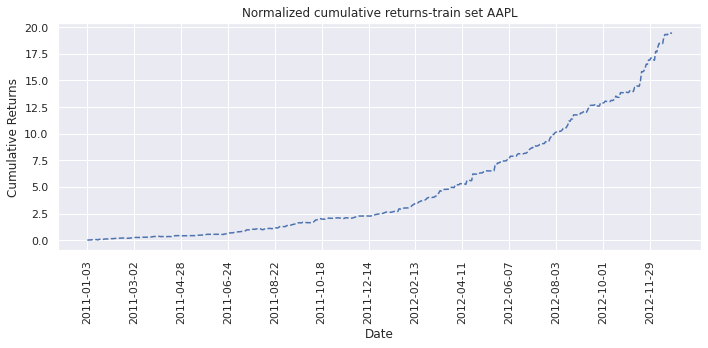

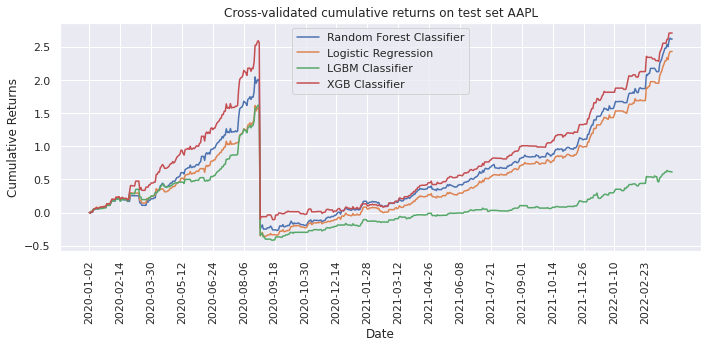

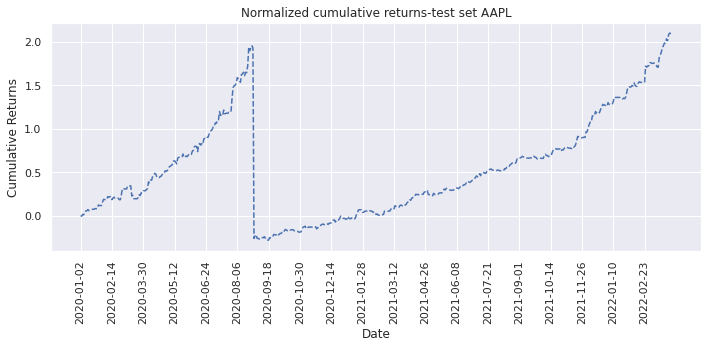

In [ ]:
train_test_equity_curves('AAPL',rfc[0][0],logreg[0][0],LGBM_classifier[0][0],XGB_classifier[0][0],\
                         rfc[1][0],logreg[1][0],LGBM_classifier[1][0],XGB_classifier[1][0])

- Random Forest and XGBoost models performed well with the test set; both had a volatile equity curve.​

- The models performed well as indicated in the Normalized cumulative return plots for test set with a positive progressive curve upto August 2020 and then came down. The curve again follows a positive trend thereon upto Feb 2022. The train set had a smooth positive curve.​

## 4.2 For IBM:

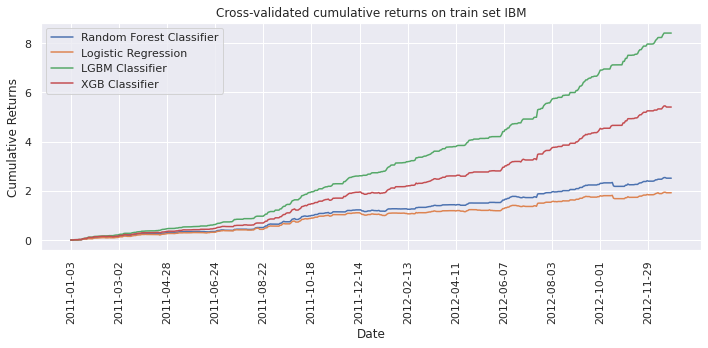

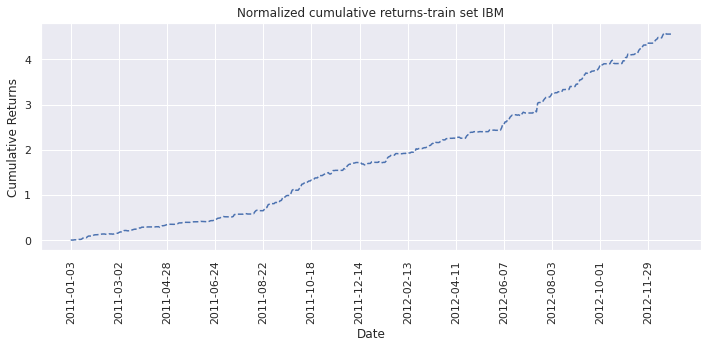

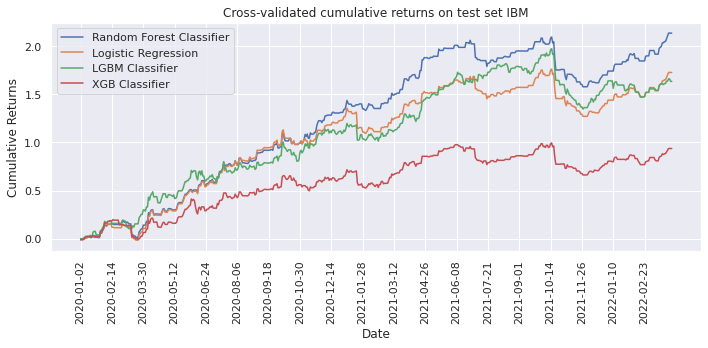

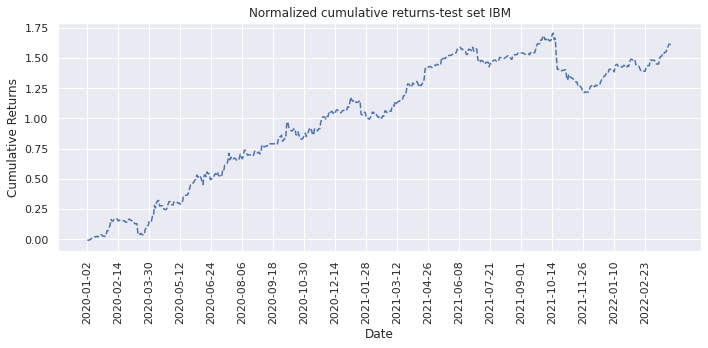

In [ ]:
train_test_equity_curves('IBM',rfc[0][1],logreg[0][1],LGBM_classifier[0][1],XGB_classifier[0][1],\
                         rfc[1][1],logreg[1][1],LGBM_classifier[1][1],XGB_classifier[1][1])

- Random Forest and Logistic Classifier models performed well with the test set; both had a volatile equity curve.​

- Random Forest Classifier outperformed all other models having more volatile equity curve, followed by Logistic and Light GBM Classifier. ​

- The models performed well as indicated in the Normalized cumulative return plots with a positive progressive curve test data, whereas the train set had a smooth positive curve.​

## 4.3 For Microsoft:

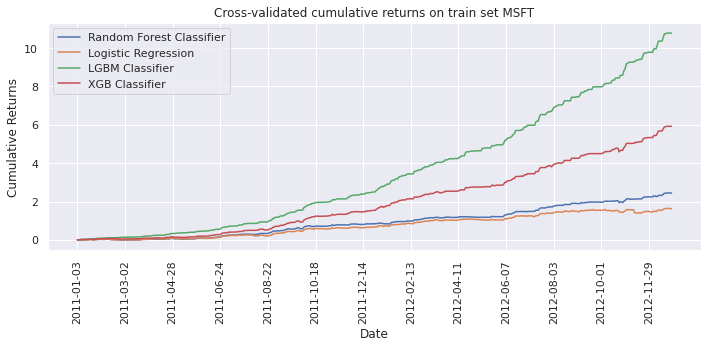

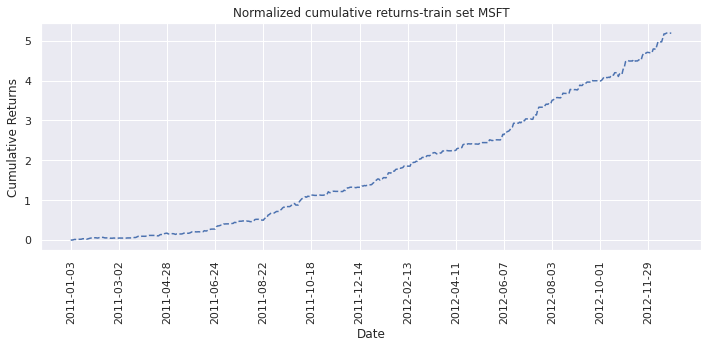

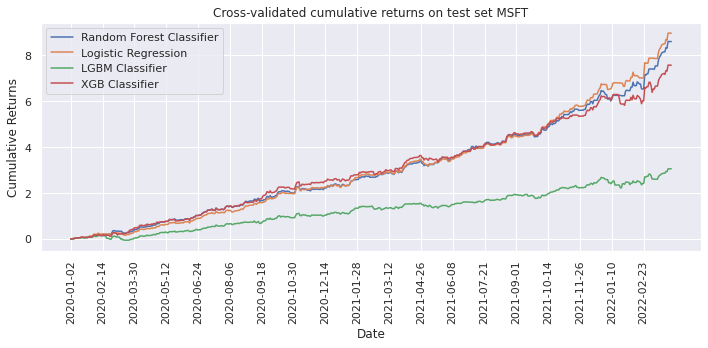

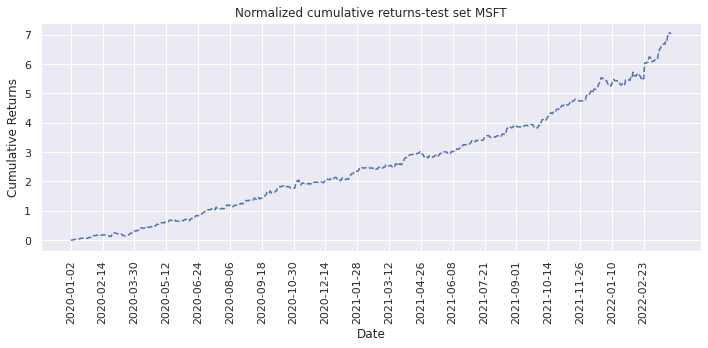

In [ ]:
train_test_equity_curves('MSFT',rfc[0][2],logreg[0][2],LGBM_classifier[0][2],XGB_classifier[0][2],\
                         rfc[1][2],logreg[1][2],LGBM_classifier[1][2],XGB_classifier[1][2])

- All models have a similar performance on CV cumulative returns on test set except LGBM which gives lowest returns. This indicates its poor performance which is also evident from the performance metrics.​

- The models performed well as indicated in the Normalized cumulative return plots with a positive progressive curve test data, whereas the train set had a smooth positive curve too.​

# 5. Alpha Lens Evaluation:

In [ ]:
def alphalens_evaluation(df2):
  df3=pd.concat(list(df2),ignore_index = False)   #combine all asset data into a DataFrame for Ahplalens
  df3.OPENPRC=Complete_DataFrame.OPENPRC
  df3.reset_index(inplace=True)
  df3.date=pd.to_datetime(df3.date)
  df3.set_index(["TICKER","date"], inplace=True)
  factor = pd.DataFrame(df3['RetPred'])
  factors = factor.swaplevel().tz_localize('EST', level='date').sort_index()
  factors = factors.drop_duplicates(keep='first')  #drop duplicates in index as Alphalens gives error with non-unique values
  factors = pd.DataFrame(factors)

  price = df3.pivot_table(index = 'date', columns = 'TICKER',values='OPENPRC')
  price.index = price.index.tz_localize('EST')
  #filter by test set dates to get the alpha lens results for those
  alpha_data = get_clean_factor_and_forward_returns(factor = factors.loc['2020-01-02':'2022-03-31'],
                                                      prices = price.loc['2020-01-02':'2022-03-31'],
                                                      quantiles=3,
                                                      periods=(1, 3, 5, 10, 21))
                                                    
  create_summary_tear_sheet(alpha_data)

## 5.1 For Random Forest:

Dropped 8.4% entries from factor data: 3.3% in forward returns computation and 5.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1.0             -0.746890  0.057791 -0.006018  0.041210    373  36.930693
2.0             -0.086602  0.076575  0.007797  0.015731    264  26.138614
3.0             -0.050847  0.092329  0.014230  0.016997    373  36.930693

Returns Analysis


1D      3D      5D  \
Ann. alpha                                      22.664   1.777   1.078   
beta                                            -0.626  -0.391  -0.507   
Mean Period Wise Return Top Quantile (bps)      95.887  35.076  24.755   
Mean Period Wise Return Bottom Quantile (bps) -106.592 -34.856 -26.018   
Mean Period Wise Spread (bps)                  202.479  71.617  53.111   

                                                  10D    21D  
Ann. alpha                                      0.239  0.026  
beta                                           -0.112  0.066  
Mean Period Wise Return Top Quantile (bps)      5.572 -0.742  
Mean Period Wise Return Bottom Quantile (bps)  -9.920 -3.135  
Mean Period Wise Spread (bps)                  15.756  1.905

Information Analysis


1D      3D     5D    10D    21D
IC Mean           1.000000e+00   0.390  0.347  0.177  0.114
IC Std.           0.000000e+00   0.730  0.752  0.798  0.806
Risk-Adjusted IC  1.663980e+16   0.534  0.462  0.222  0.141
t-stat(IC)        3.213678e+17  10.314  8.918  4.283  2.732
p-value(IC)       0.000000e+00   0.000  0.000  0.000  0.007
IC Skew           0.000000e+00  -0.905 -0.806 -0.379 -0.234
IC Kurtosis      -3.000000e+00  -0.724 -0.933 -1.516 -1.615

Turnover Analysis


1D     3D     5D    10D    21D
Quantile 1 Mean Turnover   0.691  0.635  0.639  0.675  0.693
Quantile 2 Mean Turnover   0.646  0.598  0.637  0.646  0.642
Quantile 3 Mean Turnover   0.616  0.619  0.639  0.658  0.648

1D     3D     5D  10D    21D
Mean Factor Rank Autocorrelation  0.016  0.064  0.026  0.0  0.027

<Figure size 432x288 with 0 Axes>

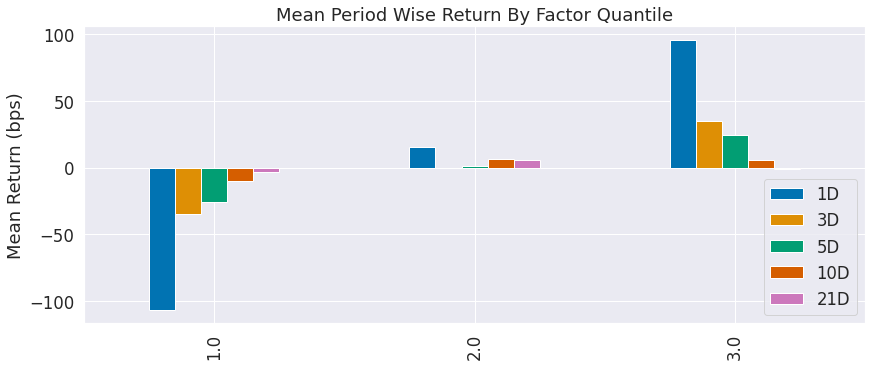

In [ ]:
alphalens_evaluation(rfc[-1])

Returns Analysis: 
- High and positive alpha values indicate stock can easily beat the market. 
- Stock's volatility is low except for 1D holding where its 0.6x market volatility. 

Information Analysis: 
- Preferred periods of stock holding with high IC: 1D, 3D & 5D. 
- IC p-value < 0.05 indicates consistent profits.

## 5.2 For XGBoost:

Dropped 14.3% entries from factor data: 3.6% in forward returns computation and 10.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1.0             -0.746890  0.084640 -0.005866  0.043615    339  37.919463
2.0             -0.041079  0.076575  0.007473  0.014685    216  24.161074
3.0             -0.086602  0.097256  0.015459  0.017896    339  37.919463

Returns Analysis


1D      3D      5D  \
Ann. alpha                                      28.556   2.320   1.220   
beta                                            -0.605  -0.463  -0.513   
Mean Period Wise Return Top Quantile (bps)     101.261  40.397  26.939   
Mean Period Wise Return Bottom Quantile (bps) -111.984 -38.385 -24.749   
Mean Period Wise Spread (bps)                  213.246  79.891  52.775   

                                                  10D    21D  
Ann. alpha                                      0.282  0.056  
beta                                           -0.139 -0.022  
Mean Period Wise Return Top Quantile (bps)      8.577  1.412  
Mean Period Wise Return Bottom Quantile (bps)  -8.729 -2.494  
Mean Period Wise Spread (bps)                  17.333  3.424

Information Analysis


1D      3D     5D    10D    21D
IC Mean           1.000000e+00   0.432  0.358  0.161  0.072
IC Std.           0.000000e+00   0.731  0.764  0.834  0.830
Risk-Adjusted IC  1.493123e+16   0.591  0.469  0.193  0.087
t-stat(IC)        2.749131e+17  10.890  8.639  3.550  1.603
p-value(IC)       0.000000e+00   0.000  0.000  0.000  0.110
IC Skew           0.000000e+00  -1.012 -0.853 -0.341 -0.145
IC Kurtosis      -3.000000e+00  -0.542 -0.886 -1.612 -1.692

Turnover Analysis


1D     3D     5D    10D    21D
Quantile 1 Mean Turnover   0.657  0.649  0.656  0.672  0.610
Quantile 2 Mean Turnover   0.651  0.638  0.668  0.631  0.662
Quantile 3 Mean Turnover   0.636  0.661  0.677  0.699  0.651

1D     3D     5D    10D   21D
Mean Factor Rank Autocorrelation  0.006  0.061 -0.011 -0.035  0.07

<Figure size 432x288 with 0 Axes>

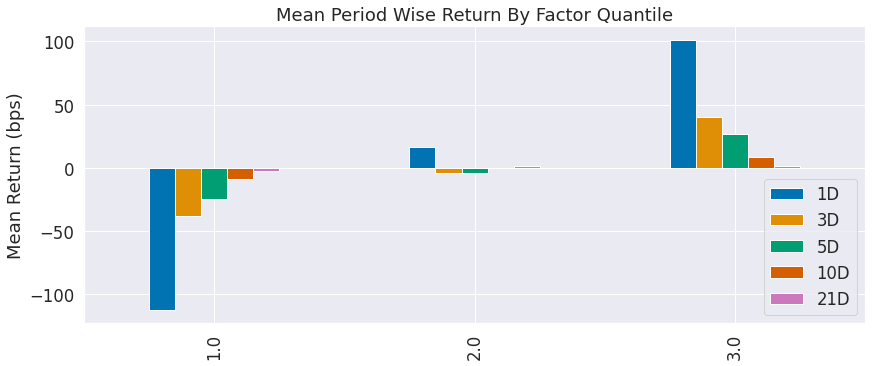

In [ ]:
alphalens_evaluation(XGB_classifier[-1])

Returns Analysis: 
- Stock can easily outperform market. 
- Stock's volatility is low except for 1D holding where its 0.5x market volatility. 

Information Analysis: 
- Preferred periods of stock holding with high IC: 1D, 3D & 5D. 
- IC p-value < 0.05 indicates significant correlation over the different horizons.

## 5.3 For Logistic Regression:

Dropped 7.5% entries from factor data: 3.0% in forward returns computation and 4.5% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1.0             -0.746890  0.057791 -0.006725  0.042764    345  34.954407
2.0             -0.086602  0.076575  0.006753  0.015271    297  30.091185
3.0             -0.050847  0.083043  0.015199  0.015925    345  34.954407

Returns Analysis


1D      3D      5D  \
Ann. alpha                                      31.117   2.057   1.316   
beta                                            -0.695  -0.460  -0.568   
Mean Period Wise Return Top Quantile (bps)     103.829  38.982  28.453   
Mean Period Wise Return Bottom Quantile (bps) -115.407 -38.631 -29.615   
Mean Period Wise Spread (bps)                  219.237  79.435  60.593   

                                                  10D    21D  
Ann. alpha                                      0.349  0.053  
beta                                           -0.235  0.027  
Mean Period Wise Return Top Quantile (bps)      7.995  0.169  
Mean Period Wise Return Bottom Quantile (bps) -13.208 -3.997  
Mean Period Wise Spread (bps)                  21.587  3.825

Information Analysis


1D      3D      5D    10D    21D
IC Mean           1.000000e+00   0.428   0.396  0.207  0.125
IC Std.           0.000000e+00   0.659   0.672  0.740  0.754
Risk-Adjusted IC  2.411284e+16   0.649   0.589  0.280  0.165
t-stat(IC)        4.478761e+17  12.059  10.939  5.201  3.070
p-value(IC)       0.000000e+00   0.000   0.000  0.000  0.002
IC Skew           0.000000e+00  -0.978  -0.927 -0.433 -0.260
IC Kurtosis      -3.000000e+00  -0.396  -0.512 -1.361 -1.506

Turnover Analysis


1D     3D     5D    10D    21D
Quantile 1 Mean Turnover   0.683  0.614  0.650  0.675  0.577
Quantile 2 Mean Turnover   0.618  0.626  0.616  0.659  0.612
Quantile 3 Mean Turnover   0.657  0.664  0.694  0.675  0.617

1D     3D     5D    10D    21D
Mean Factor Rank Autocorrelation -0.035  0.054  0.007  0.001  0.136

<Figure size 432x288 with 0 Axes>

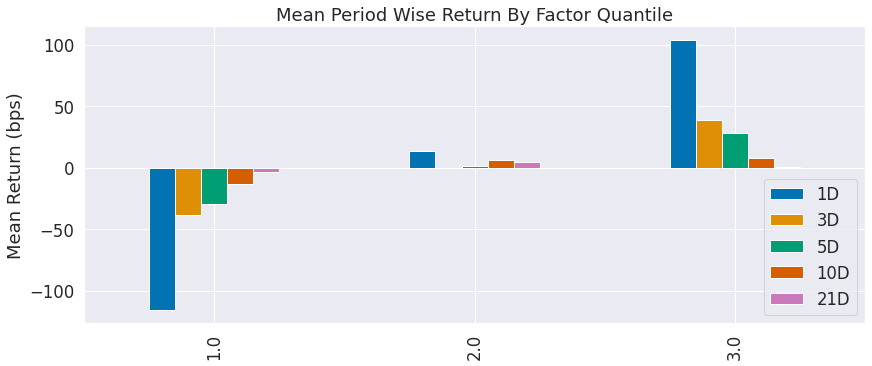

In [ ]:
alphalens_evaluation(logreg[-1])

Returns analysis:
- Returns are above market profits, and the stock can easily outperform market. 
- Stock's volatility is half of the market volatility for most horizons.
- 1D Stock Holding-->very high alpha.

Information analysis:
- Preferred periods of stock holding with high IC: 1D & 3D. 
- IC p-value < 0.05 over all the horizons.

## 5.4 For LGBM:

Dropped 14.6% entries from factor data: 3.4% in forward returns computation and 11.3% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1.0             -0.746890  0.084640 -0.006293  0.041323    381  40.531915
2.0             -0.031279  0.073797  0.006833  0.013623    178  18.936170
3.0             -0.050847  0.097256  0.013859  0.017372    381  40.531915

Returns Analysis


1D      3D      5D  \
Ann. alpha                                      20.790   1.371   0.690   
beta                                            -0.596  -0.133  -0.101   
Mean Period Wise Return Top Quantile (bps)      96.956  33.245  22.732   
Mean Period Wise Return Bottom Quantile (bps) -104.573 -34.155 -19.494   
Mean Period Wise Spread (bps)                  201.529  68.216  42.829   

                                                  10D    21D  
Ann. alpha                                      0.206  0.025  
beta                                            0.025  0.161  
Mean Period Wise Return Top Quantile (bps)      6.592  0.121  
Mean Period Wise Return Bottom Quantile (bps)  -9.518 -2.789  
Mean Period Wise Spread (bps)                  15.581  2.129

Information Analysis


1D      3D     5D    10D    21D
IC Mean           1.000000e+00   0.419  0.371  0.215  0.077
IC Std.           0.000000e+00   0.790  0.813  0.867  0.886
Risk-Adjusted IC  1.232349e+16   0.530  0.457  0.248  0.087
t-stat(IC)        2.405448e+17  10.348  8.916  4.848  1.705
p-value(IC)       0.000000e+00   0.000  0.000  0.000  0.089
IC Skew           0.000000e+00  -0.983 -0.868 -0.445 -0.150
IC Kurtosis      -3.000000e+00  -0.753 -0.994 -1.606 -1.793

Turnover Analysis


1D     3D     5D    10D    21D
Quantile 1 Mean Turnover   0.661  0.659  0.620  0.647  0.631
Quantile 2 Mean Turnover   0.638  0.629  0.682  0.637  0.573
Quantile 3 Mean Turnover   0.668  0.643  0.660  0.733  0.644

1D     3D     5D  10D    21D
Mean Factor Rank Autocorrelation -0.038 -0.006  0.032 -0.1  0.056

<Figure size 432x288 with 0 Axes>

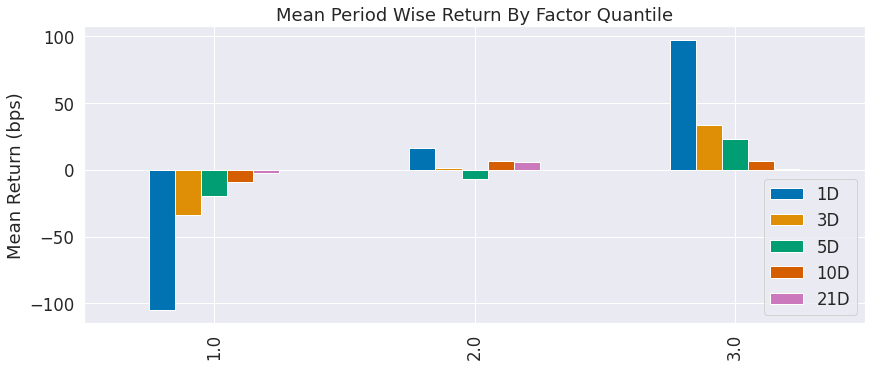

In [ ]:
alphalens_evaluation(LGBM_classifier[-1])

Returns Analysis: 
- Stock can easily outperform market. 
- Stock's volatility is low except for 1D holding where its 0.5x market volatility. 

Information Analysis: 
- Preferred periods of stock holding with high IC: 1D, 3D & 5D. 
